# Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import io
import requests
from datetime import datetime, timedelta
import numpy as np
import requests
from bs4 import BeautifulSoup

In [2]:
URL = 'https://www.worldometers.info/coronavirus/'
page = requests.get(URL)

In [3]:
soup = BeautifulSoup(page.content, 'html.parser')
today_number = [txt.text for txt in soup.find_all('tr', class_='total_row')[0].find_all('td')]
yesterday_number = [txt.text for txt in soup.find_all('tr', class_='total_row')[1].find_all('td')]

In [4]:
print("<<LATEST UPDATE>>")
print(' Total Cases \t\t: {}\n New Cases \t\t: {}\n Total Deaths \t\t: {}\n New Deaths \t\t: {}\n Total Recovered \t: {}\n\
 Active Cases \t\t: {}\n Serious Critical \t: {}'.format(today_number[1],today_number[2],today_number[3],today_number[4]\
                                                 ,today_number[5],today_number[6],today_number[7]))

# job_elems = soup.find_all('script', type='text/javascript')
# for job_elem in job_elems:
#     if (job_elem.get_text().find('Highcharts.chart')!=-1):        
#         for line in job_elem.get_text().split('\n'):            
#             if(line.find(' Highcharts.chart(')!=-1):
#                 print(line)
#             if(line.find('data')!=-1):
#                 data = line.split('[')[1].split(']')[0].split(',')
#                 print(data)

<<LATEST UPDATE>>
 Total Cases 		: 837,021
 New Cases 		: +52,362
 Total Deaths 		: 41,245
 New Deaths 		: +3,477
 Total Recovered 	: 176,040
 Active Cases 		: 619,736
 Serious Critical 	: 30,964


In [5]:
print("<<Yesterday>>")
print(' Total Cases \t\t: {}\n New Cases \t\t: {}\n Total Deaths \t\t: {}\n New Deaths \t\t: {}\n Total Recovered \t: {}\n\
 Active Cases \t\t: {}\n Serious Critical \t: {}'.format(yesterday_number[1],yesterday_number[2],yesterday_number[3],yesterday_number[4]\
                                                 ,yesterday_number[5],yesterday_number[6],yesterday_number[7]))

<<Yesterday>>
 Total Cases 		: 784,659
 New Cases 		: +61,269
 Total Deaths 		: 37,768
 New Deaths 		: +3,703
 Total Recovered 	: 164,783
 Active Cases 		: 582,108
 Serious Critical 	: 29,706


# Load CSV Files
* Total Cases

In [6]:
s0=requests.get('https://covid.ourworldindata.org/data/ecdc/total_cases.csv').content
total_cases = pd.read_csv(io.StringIO(s0.decode('utf-8'))).set_index('date')
total_cases.columns.name='Country/Region'
total_cases.tail()

Country/Region,World,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,Armenia,...,United Kingdom,United States,United States Virgin Islands,Uruguay,Uzbekistan,Vatican,Venezuela,Vietnam,Zambia,Zimbabwe
date,,,,,,,,,,,,,,,,,,,,,
2020-03-27,527767,75.0,174.0,305.0,224.0,3.0,2.0,7.0,589.0,329.0,...,11658,85991,17.0,238.0,83.0,5.0,107.0,153.0,14.0,3.0
2020-03-28,591704,91.0,186.0,305.0,267.0,4.0,2.0,7.0,690.0,372.0,...,14543,104686,19.0,238.0,104.0,5.0,119.0,169.0,16.0,5.0
2020-03-29,656866,106.0,197.0,409.0,308.0,4.0,2.0,7.0,745.0,424.0,...,17089,124665,22.0,304.0,133.0,6.0,119.0,223.0,28.0,7.0
2020-03-30,715353,114.0,212.0,454.0,334.0,7.0,2.0,7.0,820.0,424.0,...,19522,143025,30.0,309.0,145.0,6.0,119.0,228.0,29.0,7.0
2020-03-31,777798,141.0,223.0,511.0,370.0,7.0,2.0,7.0,966.0,482.0,...,22141,164620,NaN,320.0,149.0,6.0,135.0,229.0,35.0,7.0


* Total Deaths

In [7]:
s1=requests.get('https://covid.ourworldindata.org/data/ecdc/total_deaths.csv').content
total_deaths = pd.read_csv(io.StringIO(s1.decode('utf-8'))).set_index('date')
total_deaths.columns.name='Country/Region'
total_deaths.tail()

Country/Region,World,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,Armenia,...,United Kingdom,United States,United States Virgin Islands,Uruguay,Uzbekistan,Vatican,Venezuela,Vietnam,Zambia,Zimbabwe
date,,,,,,,,,,,,,,,,,,,,,
2020-03-27,23670,1.0,6.0,21.0,3.0,0.0,0.0,0.0,12.0,1.0,...,578,1296,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2020-03-28,26988,2.0,9.0,21.0,3.0,0.0,0.0,0.0,17.0,1.0,...,759,1707,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2020-03-29,30449,3.0,10.0,26.0,4.0,0.0,0.0,0.0,19.0,3.0,...,1019,2191,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2020-03-30,33574,4.0,10.0,29.0,6.0,2.0,0.0,0.0,20.0,3.0,...,1228,2509,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
2020-03-31,37272,4.0,12.0,31.0,8.0,2.0,0.0,0.0,24.0,3.0,...,1408,3170,NaN,1.0,2.0,0.0,3.0,0.0,0.0,1.0


* Total Recovered

In [8]:
s2=requests.get('https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_recovered_global.csv&filename=time_series_covid19_recovered_global.csv').content
total_recovered_raw = pd.read_csv(io.StringIO(s2.decode('utf-8')))
tr = total_recovered_raw.drop(['Lat','Long'],axis=1).groupby('Country/Region').sum().transpose()
tr = tr.rename(columns={"US":"United States",'Korea, South':'South Korea'})
tr_idx = tr.index
tr_idx_formatted = [(datetime.strptime(idx,'%m/%d/%y').strftime('%Y-%m-%d')) for idx in tr_idx]
tr = tr.set_index([pd.Series(tr_idx_formatted)])
tr_sum = tr.sum(axis=1).to_frame()
tr_sum.columns={"World"}
total_recovered = pd.concat([tr, tr_sum.reindex(tr.index)], axis=1)
total_recovered.index.names=['date']
total_recovered.tail()

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Zambia,Zimbabwe,World
date,,,,,,,,,,,,,,,,,,,,,
2020-03-26,2,17,29,1,0,0,63,18,172,112,...,52,150,0,0,15,20,17,0,0,122150
2020-03-27,2,31,29,1,0,0,72,28,194,225,...,52,151,0,5,31,20,17,0,0,130915
2020-03-28,2,31,31,1,0,0,72,30,244,225,...,52,151,0,5,39,21,18,0,0,139415
2020-03-29,2,33,31,1,0,0,72,30,244,479,...,58,151,0,7,39,25,18,0,0,149082
2020-03-30,2,44,37,10,0,0,228,30,257,636,...,61,171,0,7,39,55,18,0,0,164566


# Select focused data
* List current top twenties countries and Singapore + Malaysia

In [9]:
# today_str = datetime.utcnow().date().strftime('%Y-%m-%d')
# yesterday_str = (datetime.utcnow().date()-timedelta(days=1)).strftime('%Y-%m-%d')
tc_idx = total_cases.index
tc_latest_date = tc_idx[len(tc_idx)-1]
print("Latest Data Date : " , tc_latest_date)
total_cases = total_cases.sort_values(by=tc_latest_date,axis=1,ascending=False)
total_deaths = total_deaths.sort_values(by=tc_latest_date,axis=1,ascending=False)
Top_20 = list(total_cases.columns[0:21])
print('Top 20 countries are : ', Top_20[1:21])
Interested_countries = Top_20 + ['Singapore','Malaysia']

Latest Data Date :  2020-03-31
Top 20 countries are :  ['United States', 'Italy', 'Spain', 'China', 'Germany', 'France', 'Iran', 'United Kingdom', 'Switzerland', 'Belgium', 'Netherlands', 'Turkey', 'South Korea', 'Austria', 'Canada', 'Portugal', 'Brazil', 'Australia', 'Israel', 'Norway']


* Filter with only the interested countries

In [10]:
IC_total_cases = total_cases[Interested_countries].fillna(method='ffill').fillna(0)
IC_total_deaths = total_deaths[Interested_countries].fillna(method='ffill').fillna(0)
IC_total_recovered = total_recovered[Interested_countries]

* Get growth rate tables

In [11]:
IC_total_cases_inc = IC_total_cases.diff(axis=0).fillna(0)
IC_total_cases_inc.tail()

Country/Region,World,United States,Italy,Spain,China,Germany,France,Iran,United Kingdom,Switzerland,...,South Korea,Austria,Canada,Portugal,Brazil,Australia,Israel,Norway,Singapore,Malaysia
date,,,,,,,,,,,,,,,,,,,,,
2020-03-27,59718.0,16797.0,6153.0,8578.0,94.0,5780.0,3922.0,2389.0,2129.0,1000.0,...,91.0,1141.0,633.0,549.0,482.0,367.0,297.0,240.0,26.0,235.0
2020-03-28,63937.0,18695.0,5959.0,7871.0,119.0,6294.0,3809.0,2926.0,2885.0,1390.0,...,146.0,668.0,671.0,724.0,502.0,212.0,369.0,425.0,138.0,130.0
2020-03-29,65162.0,19979.0,5974.0,8189.0,113.0,3965.0,4611.0,3076.0,2546.0,1048.0,...,105.0,594.0,697.0,902.0,487.0,431.0,584.0,264.0,71.0,159.0
2020-03-30,58487.0,18360.0,5217.0,6549.0,98.0,4751.0,2599.0,2901.0,2433.0,1122.0,...,78.0,522.0,869.0,792.0,352.0,284.0,628.0,257.0,41.0,150.0
2020-03-31,62445.0,21595.0,4050.0,6398.0,84.0,4615.0,4376.0,3186.0,2619.0,1138.0,...,125.0,805.0,1169.0,446.0,323.0,464.0,226.0,124.0,0.0,156.0


In [12]:
# Moving average
IC_total_cases_inc_ma = IC_total_cases_inc.rolling(window=3).mean()
IC_total_cases_inc_ma.tail()

Country/Region,World,United States,Italy,Spain,China,Germany,France,Iran,United Kingdom,Switzerland,...,South Korea,Austria,Canada,Portugal,Brazil,Australia,Israel,Norway,Singapore,Malaysia
date,,,,,,,,,,,,,,,,,,,,,
2020-03-27,49949.666667,13183.000000,5537.333333,7699.666667,91.333333,4358.666667,3099.666667,2119.000000,1669.333333,899.666667,...,98.333333,847.666667,790.666667,494.666667,341.333333,447.666667,408.000000,261.666667,28.333333,171.000000
2020-03-28,58286.333333,16485.000000,5774.000000,8128.666667,105.000000,5676.000000,3554.000000,2507.000000,2155.333333,1105.000000,...,113.666667,805.000000,910.000000,635.333333,405.333333,318.333333,368.333333,338.333333,58.000000,179.000000
2020-03-29,62939.000000,18490.333333,6028.666667,8212.666667,108.666667,5346.333333,4114.000000,2797.000000,2520.000000,1146.000000,...,114.000000,801.000000,667.000000,725.000000,490.333333,336.666667,416.666667,309.666667,78.333333,174.666667
2020-03-30,62528.666667,19011.333333,5716.666667,7536.333333,110.000000,5003.333333,3673.000000,2967.666667,2621.333333,1186.666667,...,109.666667,594.666667,745.666667,806.000000,447.000000,309.000000,527.000000,315.333333,83.333333,146.333333
2020-03-31,62031.333333,19978.000000,5080.333333,7045.333333,98.333333,4443.666667,3862.000000,3054.333333,2532.666667,1102.666667,...,102.666667,640.333333,911.666667,713.333333,387.333333,393.000000,479.333333,215.000000,37.333333,155.000000


# Plot data

C:\Users\kohte\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\kohte\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


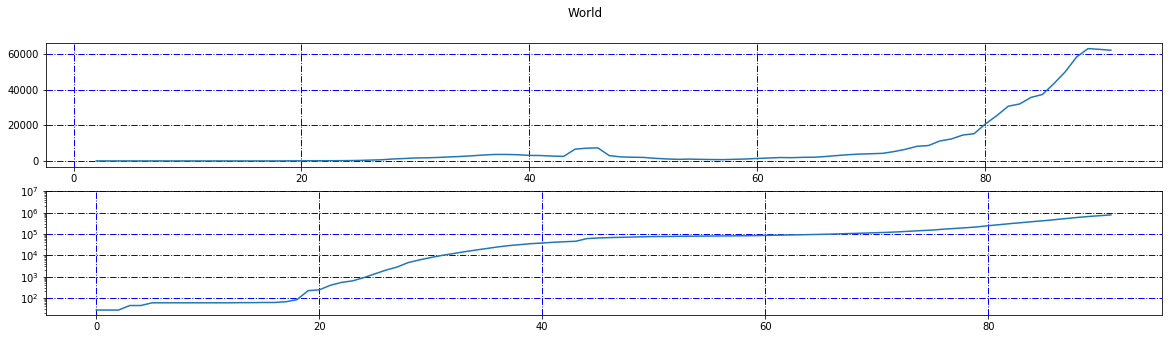

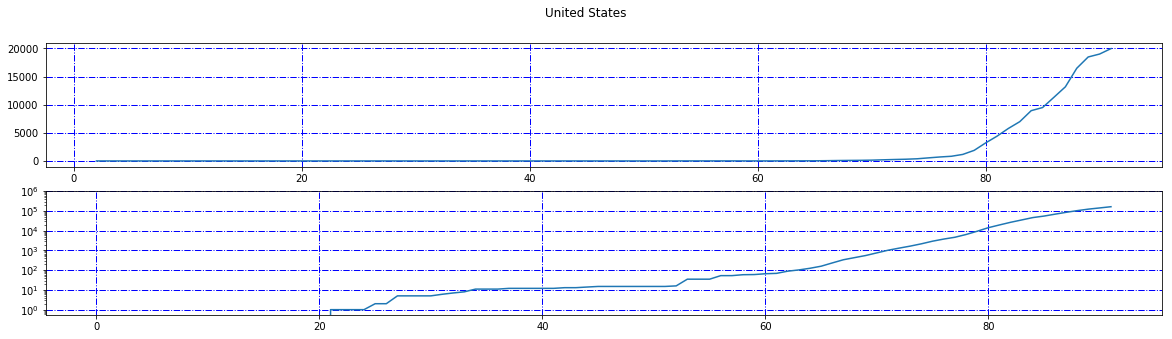

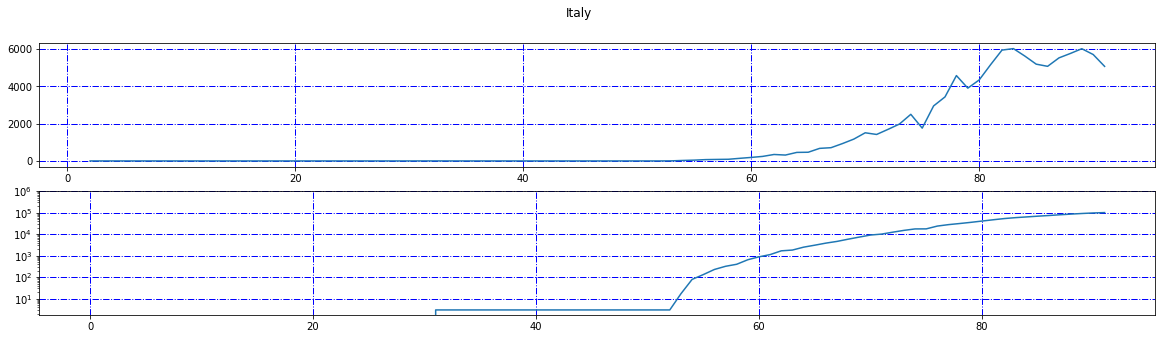

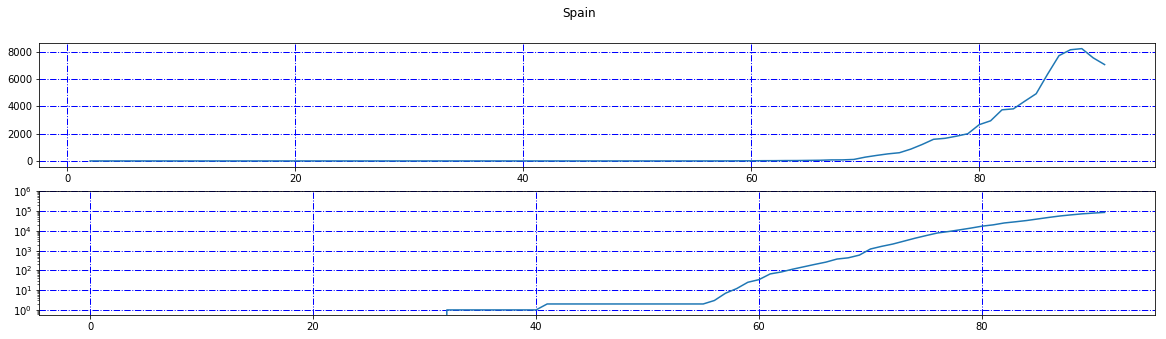

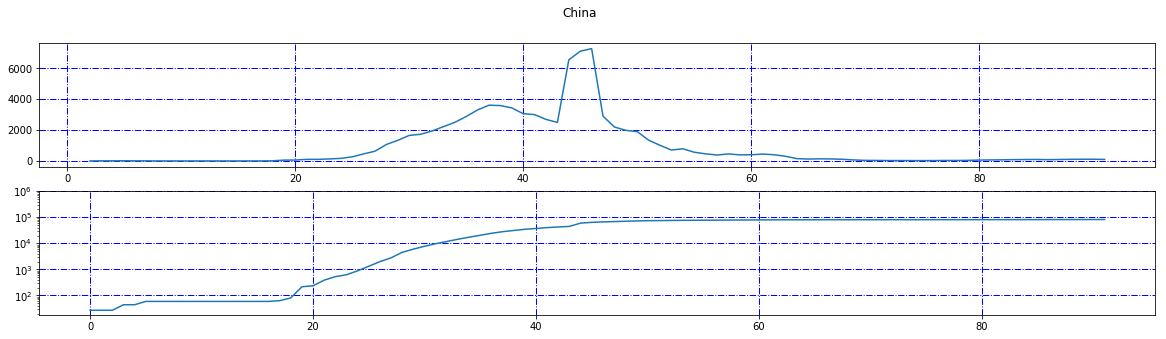

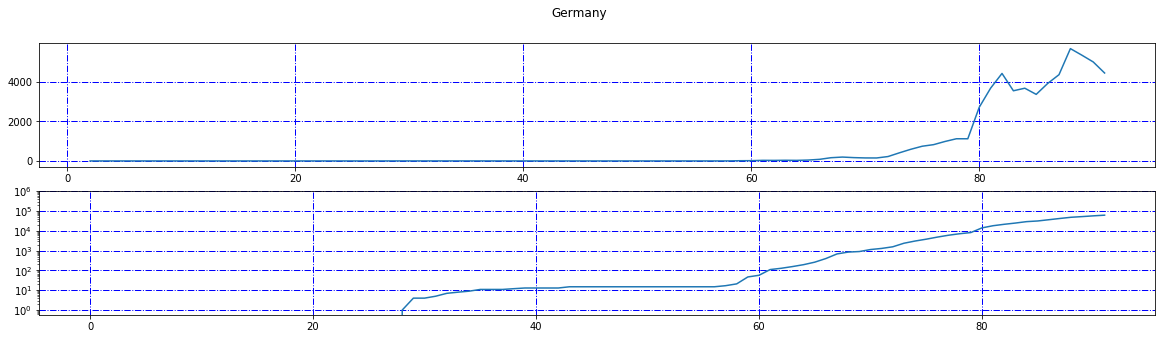

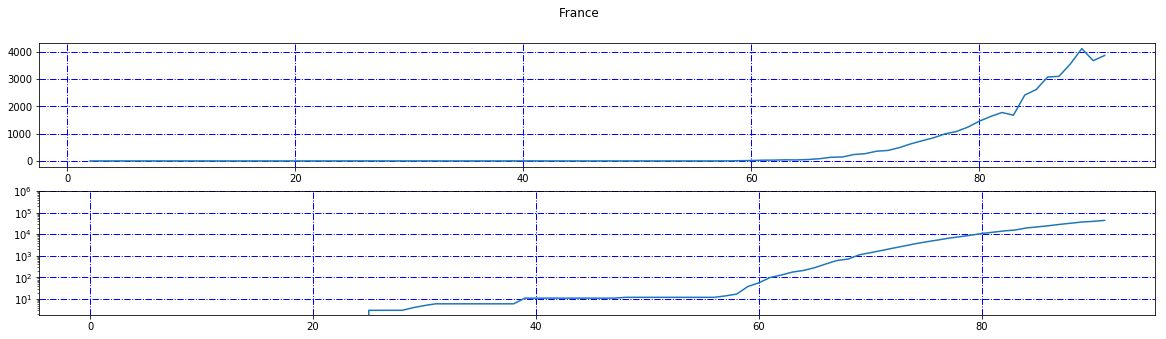

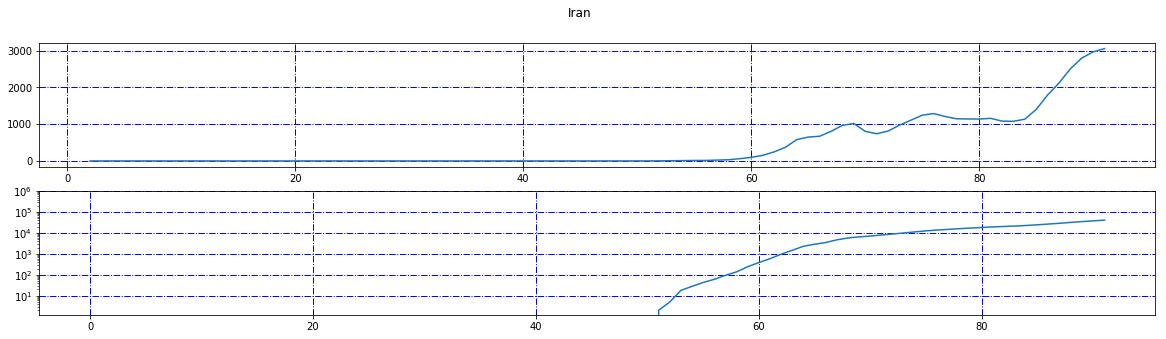

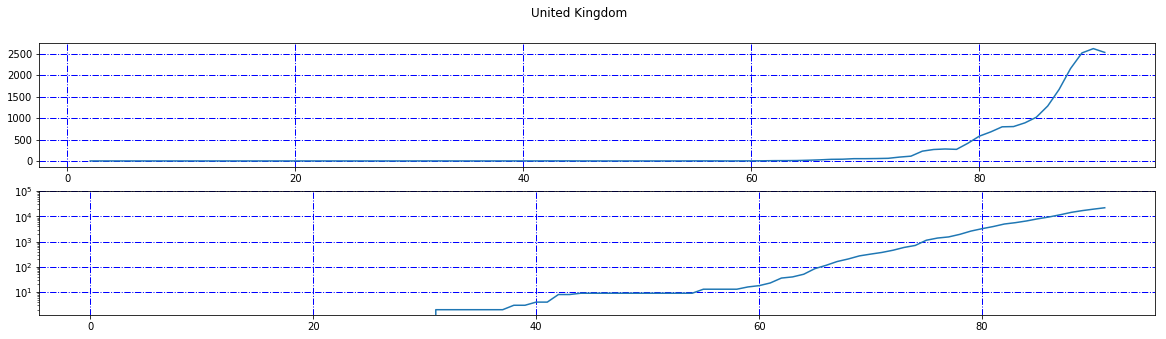

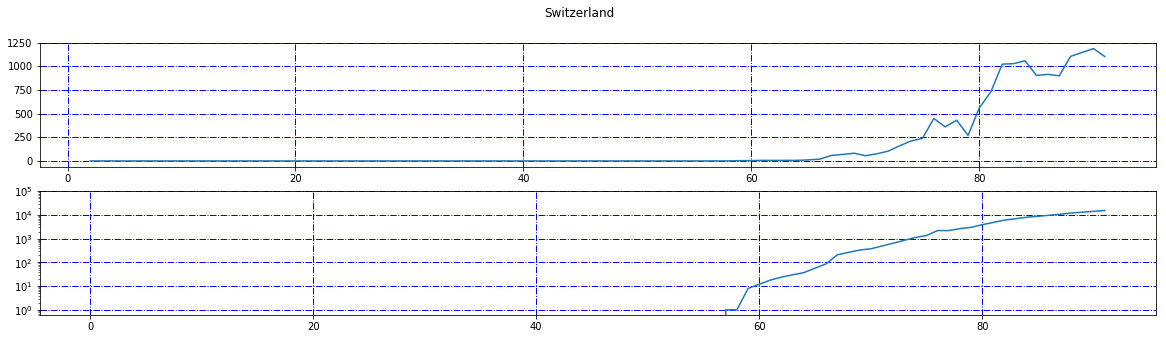

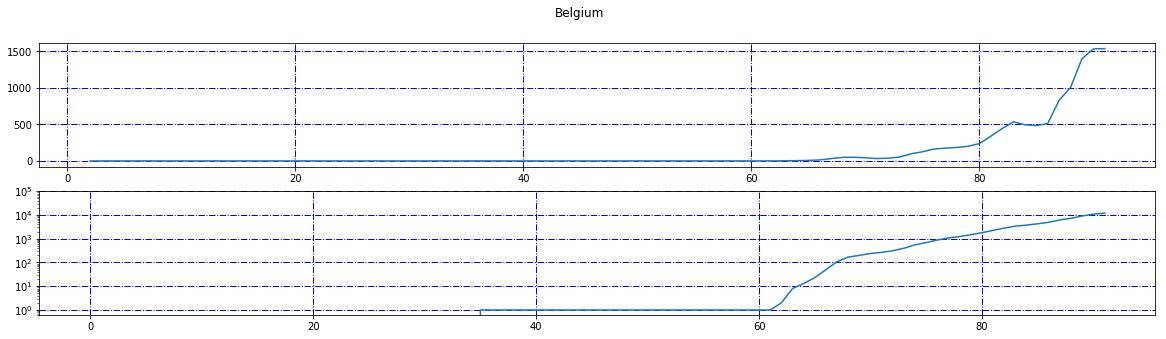

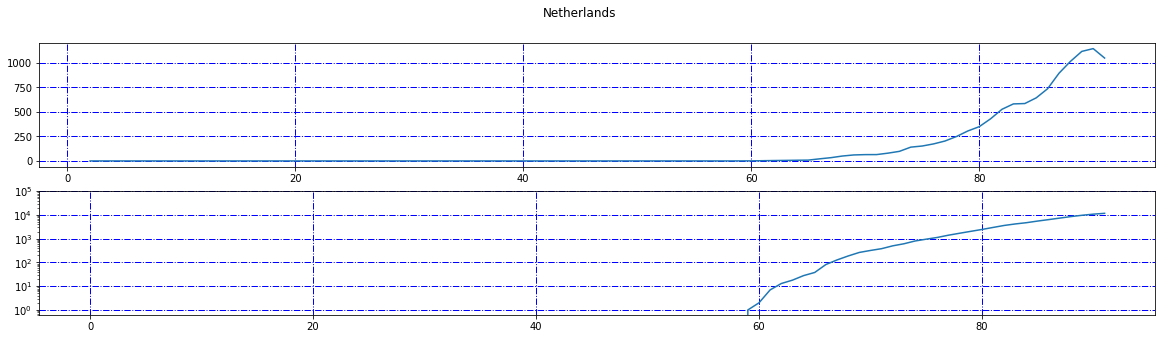

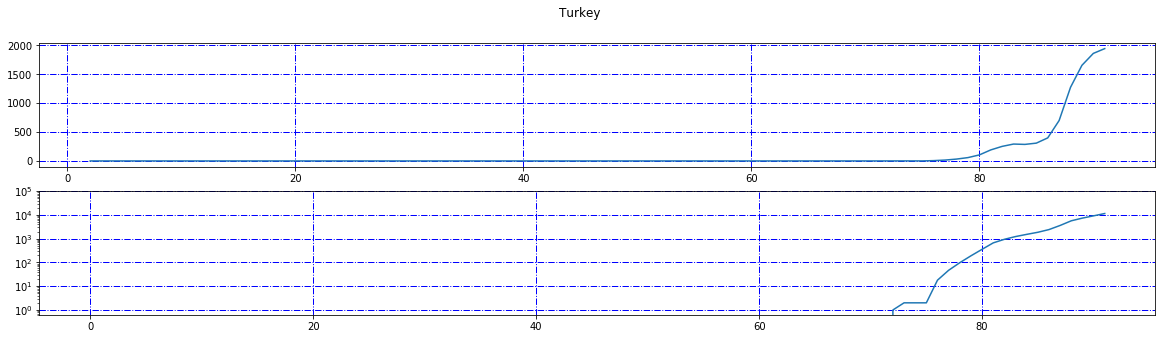

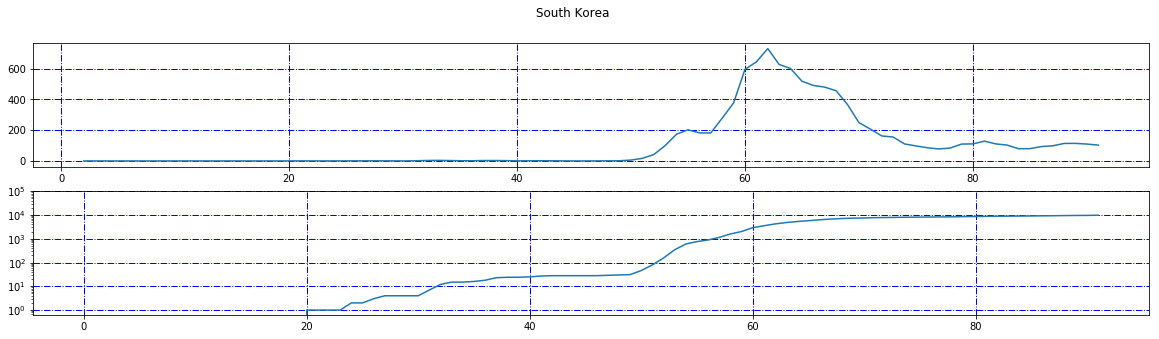

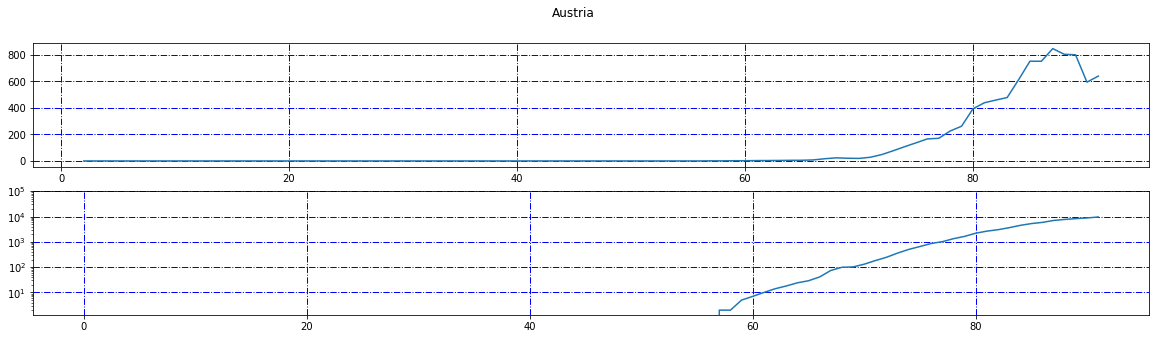

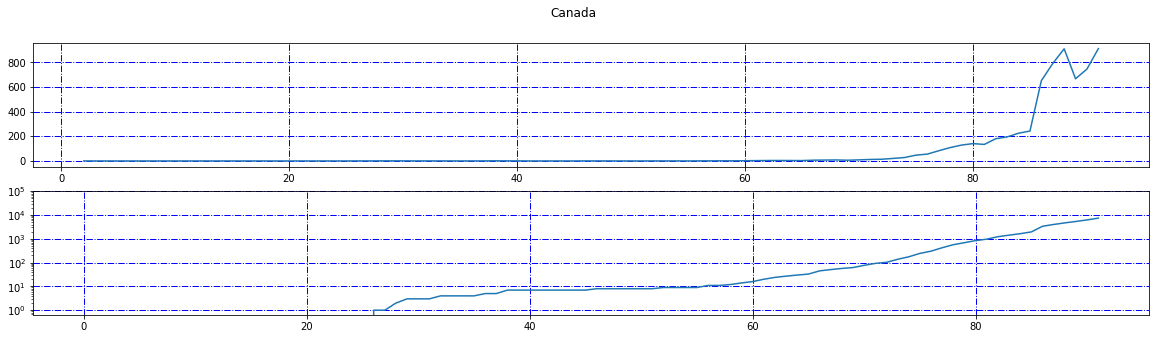

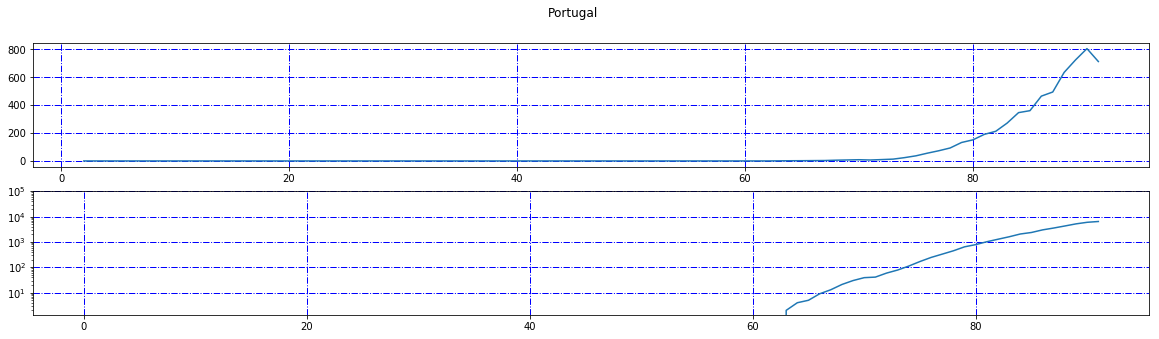

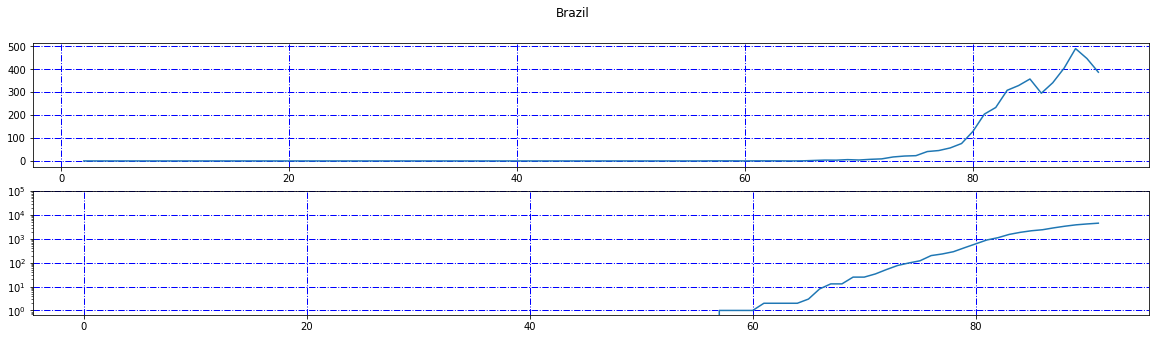

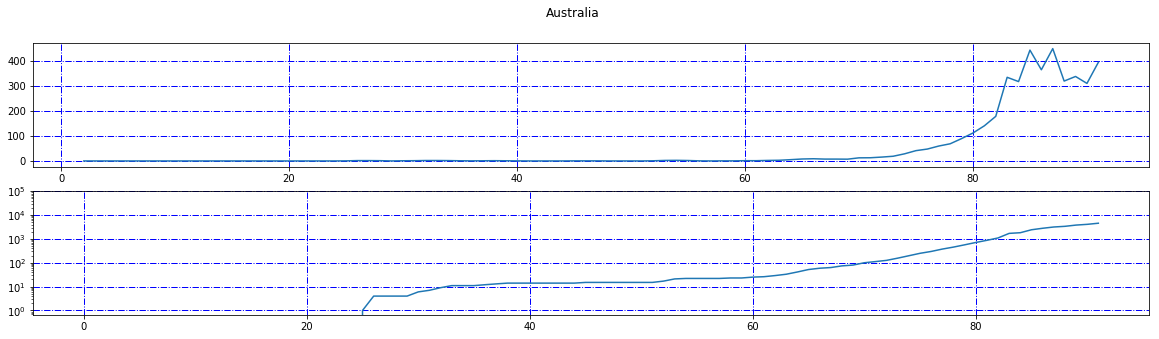

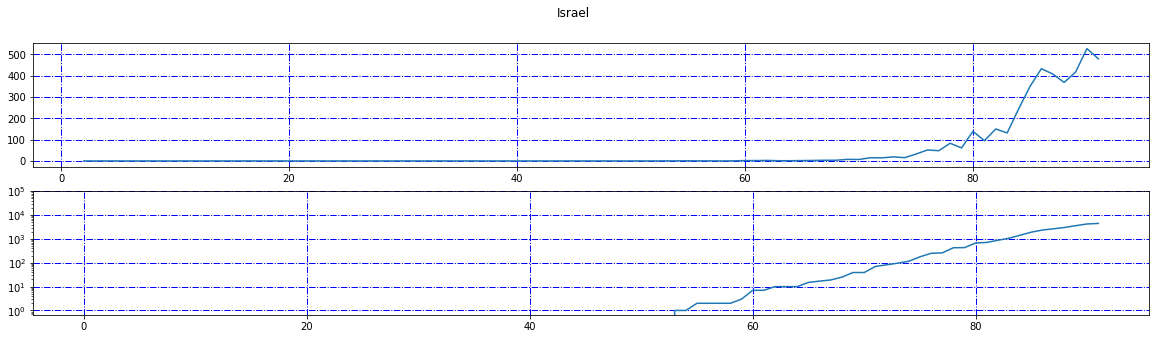

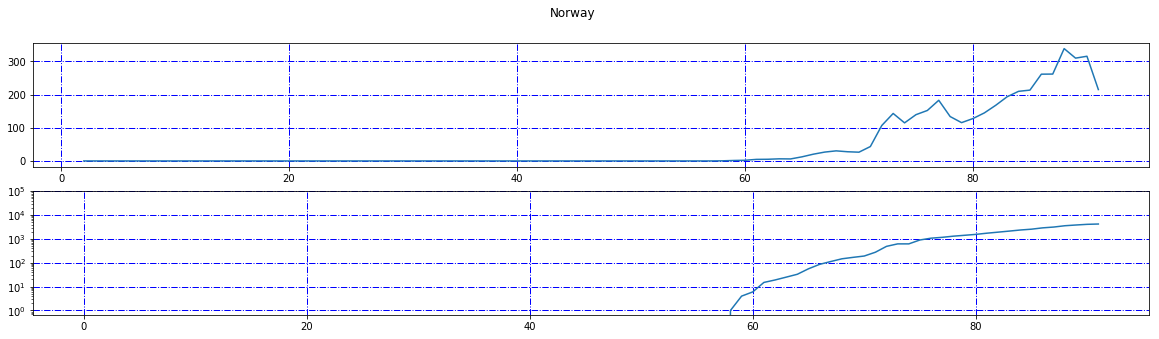

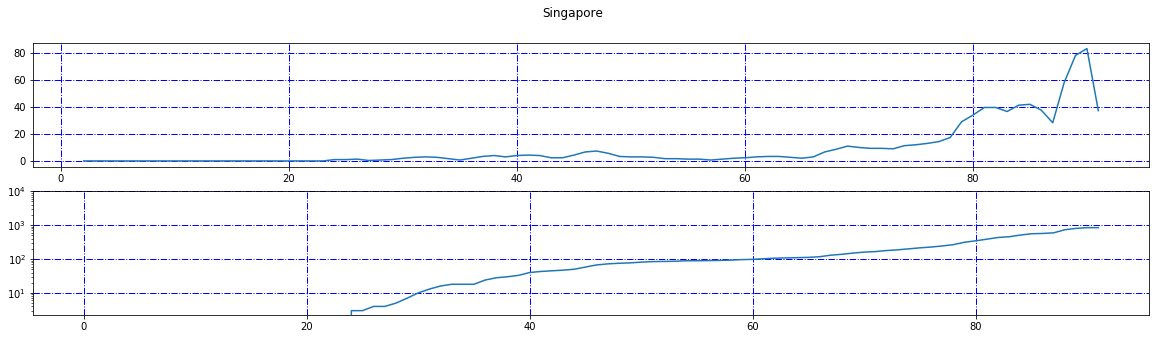

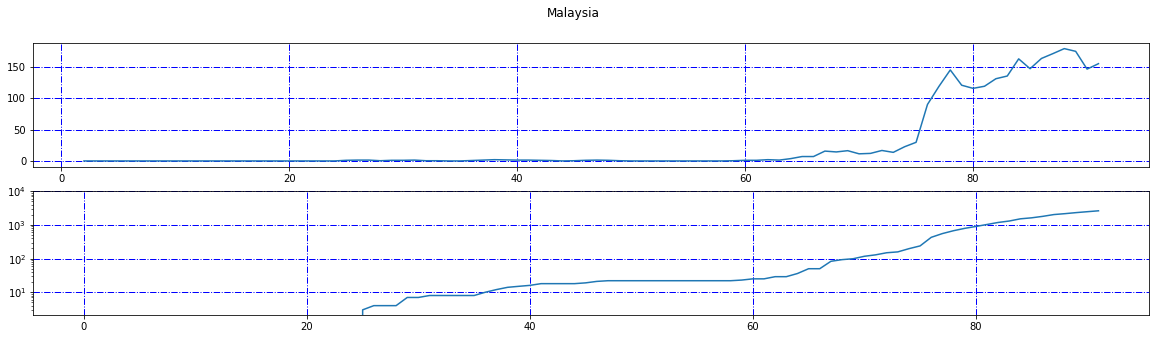

In [13]:
for country in Interested_countries:
    plt.rcParams["figure.figsize"] = (20,5)
    fig, (ax1, ax2) = plt.subplots(2)        
    ax1.grid(color='b', linestyle='-.', linewidth=1)
    ax1.plot(list(IC_total_cases_inc_ma[country]))   
    ax2.set_yscale('log')
    ls_IC_total_cases = list(IC_total_cases[country])
    ax2.plot(ls_IC_total_cases)
    ax2.grid(color='b', linestyle='-.', linewidth=1)
    ax2.set_ylim([0,10**(round(np.log10(max(ls_IC_total_cases)))+1)])
    fig.suptitle(country)
    

# Plot table

In [14]:
tr_idx = total_recovered.index
tr_latest_date = tr_idx[len(tr_idx)-1]
print(tr_latest_date)
last_day_rate = [int(IC_total_cases_inc[country][-1]) for country in Interested_countries]
last_3days_rate = [int(IC_total_cases_inc_ma[country][-1].mean()) for country in Interested_countries]
last_7days_rate = [int(IC_total_cases_inc[country][-7:-1].mean()) for country in Interested_countries]
TotalCase = [IC_total_cases[country][-1] for country in Interested_countries]
TotalDeath = [IC_total_deaths[country][-1] for country in Interested_countries]
TotalRecovered = list(IC_total_recovered.loc[tr_latest_date,:])
DeathRatio = [td/(tr+td)*100 for td, tr in zip(TotalDeath, TotalRecovered)]
Dropping = [l3<l7 for l3, l7 in zip(last_3days_rate, last_7days_rate)]


last_rate_dict = {'country':Interested_countries, 'Last day inc':last_day_rate,'Last 3 days average inc' :last_3days_rate, 
                  'Last 7 days inc':last_7days_rate, 'TotalCase': TotalCase, 'TotalRecovered':TotalRecovered,
                  'TotalDeath': TotalDeath, 'DeathRatio %': DeathRatio, 'Dropping':Dropping}
pd.DataFrame.from_dict(last_rate_dict).set_index('country')

2020-03-30


,Last day inc,Last 3 days average inc,Last 7 days inc,TotalCase,TotalRecovered,TotalDeath,DeathRatio %,Dropping
country,,,,,,,,
World,62445,62031,56239,777798.0,164566,37272.0,18.466295,False
United States,21595,19978,16097,164620.0,5644,3170.0,35.965509,False
Italy,4050,5080,5627,101739.0,14620,11591.0,44.221892,True
Spain,6398,7045,7618,85195.0,16780,7340.0,30.431177,True
China,84,98,100,82241.0,75923,3309.0,4.176343,True
Germany,4615,4443,4681,61913.0,13500,583.0,4.139743,True
France,4376,3862,3386,44550.0,7964,3024.0,27.520932,False
Iran,3186,3054,2543,41495.0,13911,2757.0,16.540677,False
United Kingdom,2619,2532,2145,22141.0,171,1408.0,89.170361,False
